# Post-processing CSV

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime


import cv2
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import sys
sys.path.append("../common/")

In [4]:
from data_utils import get_scalers, LABELS, TRAIN_IMAGE_IDS
from image_utils import get_image_data
from submission_utils import submission_iterator, write_shp_from_polygons, write_shp_from_csv, write_shp_from_mask
from submission_utils import get_scaled_polygons, get_polygons, compute_label_image, get_data_csv
from submission_utils import rewrite_submission

In [5]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [6]:
CSV_FILE_NEW = "../results/sub_mix_20170304_2329.csv"
CSV_FILE_TRAIN = "../results/sub_model_1_20170304_1826_nan.csv"
CSV_FILE_OLD = "../results/sub_unet_3D_mix_th_80_3_P_M_A_20170218_2057_0.8906966279736366_reduced.csv"


Compare submission's predictions raw and post-processed on trained data with ground truth

In [7]:
from np_metrics import score

Get common image ids from submission file and training image ids

In [8]:
import pandas as pd
import os

In [9]:
df = pd.read_csv(os.path.join('..', 'input', 'sample_submission.csv'))
submission_image_ids = df['ImageId'].unique()

In [18]:
print TRAIN_IMAGE_IDS

['6040_2_2' '6120_2_2' '6120_2_0' '6090_2_0' '6040_1_3' '6040_1_0'
 '6100_1_3' '6010_4_2' '6110_4_0' '6140_3_1' '6110_1_2' '6100_2_3'
 '6150_2_3' '6160_2_1' '6140_1_2' '6110_3_1' '6010_4_4' '6170_2_4'
 '6170_4_1' '6170_0_4' '6060_2_3' '6070_2_3' '6010_1_2' '6040_4_4'
 '6100_2_2']


In [10]:
set(TRAIN_IMAGE_IDS) & set(submission_image_ids)

{'6010_1_2', '6040_4_4', '6070_2_3', '6100_2_2'}

In [22]:
def write_shp_pred_pp(image_id, csv_file):
    data_csv = get_data_csv(image_id, csv_file)
    assert data_csv is not None, "No data_csv"
    write_shp_from_csv("../results/shp/%s_new.shp" % image_id, data_csv)
    polygons = get_scaled_polygons(data_csv)
    y_pred_raw = compute_label_image(image_id, polygons)
    y_pred_pp = mask_postprocessing(y_pred_raw, class_pp_func_list)
    write_shp_from_mask("../results/shp/%s_pp.shp" % image_id, image_id, y_pred_pp)

In [11]:
def compare_true_pred_pp(image_id, csv_file, write_shp=True):
    y_true = get_image_data(image_id, 'label')
    data_csv = get_data_csv(image_id, csv_file)
    assert data_csv is not None, "No data_csv"
    if write_shp:
        write_shp_from_csv("../results/shp/%s_new.shp" % image_id, data_csv)
    polygons = get_scaled_polygons(data_csv)
    y_pred_raw = compute_label_image(image_id, polygons)
#     y_pred_raw[:,:,2] = 0 
#     y_pred_raw[:,:,4] = 0 
#     y_pred_raw[:,:,5] = 0 
#     y_pred_raw[:,:,6] = 0 
    
    h = min(y_true.shape[0], y_pred_raw.shape[0])
    w = min(y_true.shape[1], y_pred_raw.shape[1])
    s1 = score(y_true[:h,:w,:], y_pred_raw[:h,:w,:])    
    print "True vs Pred Raw: ", s1
    
    y_pred_pp = mask_postprocessing(y_pred_raw, class_pp_func_list)
#     y_pred_pp[:,:,2] = 0    
#     y_pred_pp[:,:,4] = 0 
#     y_pred_pp[:,:,5] = 0 
#     y_pred_pp[:,:,6] = 0 
    
    h = min(y_true.shape[0], y_pred_pp.shape[0])
    w = min(y_true.shape[1], y_pred_pp.shape[1])
    s2 = score(y_true[:h,:w,:], y_pred_pp[:h,:w,:])
    print "True vs Pred PP: ", s2
    if write_shp:
        write_shp_from_mask("../results/shp/%s_pp.shp" % image_id, image_id, y_pred_pp)
        
    return s1, s2

In [13]:
from postprocessing_utils import path_postprocessing, crop_postprocessing, mask_postprocessing
from postprocessing_utils import trees_postprocessing, buildings_postprocessing

class_pp_func_list = {
#     1: buildings_postprocessing,
#     4: path_postprocessing, # Enhancement of :  0.508556447029 -> 0.509641740322 from Training Dataset
#     5: trees_postprocessing, # Enhancement of : 0.508556447029 -> 0.508932631016 from Training Dataset  
    6: crop_postprocessing # Enhancement of : 0.508556447029 -> 0.530760986805 from Training Dataset
}

In [21]:
# image_id = "6010_1_2"
# image_id = "6040_4_4"
# image_id = "6100_2_2"
image_id = "6120_2_0"


_ = compare_true_pred_pp(image_id, CSV_FILE_NEW, write_shp=True)

AssertionError: Image is not found: id=6120_2_4, type=label

In [23]:
image_id = "6120_2_4"
write_shp_pred_pp(image_id, CSV_FILE_NEW)

Written succesfully file :  ../results/shp/6120_2_4_new.shp


Self-intersection at or near point 2970.818181818182 3341.7272727272725
Self-intersection at or near point 1533 1036
Self-intersection at or near point 3162.294117647059 2623.9411764705883
Self-intersection at or near point 2055.625 962.625


Written succesfully file :  ../results/shp/6120_2_4_pp.shp


In [87]:
# a = np.zeros((10, 10, 3), dtype=np.uint8)
# a[2:5,2:5, 0] = 1
# a[5:7,5:7, 1] = 1
# b = np.zeros_like(a)
# score(b, a)

Check on all training data:

In [29]:
train_ids = TRAIN_IMAGE_IDS
# train_ids = list(set(TRAIN_IMAGE_IDS) & set(submission_image_ids))

In [43]:
total_s1 = 0
total_s2 = 0
for image_id in train_ids:
    print "--", image_id
    s1, s2 = compare_true_pred_pp(image_id, CSV_FILE_TRAIN, write_shp=False)
    total_s1 += s1
    total_s2 += s2

total_s1 *= 1.0 / len(train_ids)
total_s2 *= 1.0 / len(train_ids)
print "Final score: ", total_s1, total_s2

-- 6040_2_2
True vs Pred Raw:  0.760823
True vs Pred PP:  0.852596
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.306014
-- 6120_2_0
True vs Pred Raw:  0.422918
True vs Pred PP:  0.423093
-- 6090_2_0
True vs Pred Raw:  0.51103
True vs Pred PP:  0.512783
-- 6040_1_3
True vs Pred Raw:  0.773645
True vs Pred PP:  0.772858
-- 6040_1_0
True vs Pred Raw:  0.691344
True vs Pred PP:  0.782077
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.354677
-- 6010_4_2
True vs Pred Raw:  0.677029
True vs Pred PP:  0.677597
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.402467
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.339154
-- 6110_1_2
True vs Pred Raw:  0.323997
True vs Pred PP:  0.328477
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.292511
-- 6150_2_3
True vs Pred Raw:  0.7468
True vs Pred PP:  0.750573
-- 6160_2_1
True vs Pred Raw:  0.502619
True vs Pred PP:  0.596526
-- 6140_1_2
True vs Pred Raw:  0.425552
True vs Pred PP:  0.43038

Crops only

-- 6040_2_2
True vs Pred Raw:  0.760823
True vs Pred PP:  0.851732
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.303953
-- 6120_2_0
True vs Pred Raw:  0.422918
True vs Pred PP:  0.422366
-- 6090_2_0
True vs Pred Raw:  0.51103
True vs Pred PP:  0.511785
-- 6040_1_3
True vs Pred Raw:  0.773645
True vs Pred PP:  0.773188
-- 6040_1_0
True vs Pred Raw:  0.691344
True vs Pred PP:  0.782253
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.354572
-- 6010_4_2
True vs Pred Raw:  0.677029
True vs Pred PP:  0.677029
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.398847
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.335808
-- 6110_1_2
True vs Pred Raw:  0.323997
True vs Pred PP:  0.324353
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.293448
-- 6150_2_3
True vs Pred Raw:  0.7468
True vs Pred PP:  0.746512
-- 6160_2_1
True vs Pred Raw:  0.502619
True vs Pred PP:  0.593528
-- 6140_1_2
True vs Pred Raw:  0.425552
True vs Pred PP:  0.425638
-- 6110_3_1
True vs Pred Raw:  0.355562
True vs Pred PP:  0.35621
-- 6010_4_4
True vs Pred Raw:  0.665605
True vs Pred PP:  0.756514
-- 6170_2_4
True vs Pred Raw:  0.583704
True vs Pred PP:  0.587184
-- 6170_4_1
True vs Pred Raw:  0.753473
True vs Pred PP:  0.753473
-- 6170_0_4
True vs Pred Raw:  0.5827
True vs Pred PP:  0.5827
-- 6060_2_3
True vs Pred Raw:  0.456037
True vs Pred PP:  0.455761
-- 6070_2_3
True vs Pred Raw:  0.304483
True vs Pred PP:  0.395392
-- 6010_1_2
True vs Pred Raw:  0.574222
True vs Pred PP:  0.665132
-- 6040_4_4
True vs Pred Raw:  0.667234
True vs Pred PP:  0.667234
-- 6100_2_2
True vs Pred Raw:  0.256762
True vs Pred PP:  0.254412


Crops + Trees + Path

-- 6040_2_2
True vs Pred Raw:  0.760823
True vs Pred PP:  0.852596
-- 6120_2_2
True vs Pred Raw:  0.301466
True vs Pred PP:  0.306014
-- 6120_2_0
True vs Pred Raw:  0.422918
True vs Pred PP:  0.423093
-- 6090_2_0
True vs Pred Raw:  0.51103
True vs Pred PP:  0.512783
-- 6040_1_3
True vs Pred Raw:  0.773645
True vs Pred PP:  0.772858
-- 6040_1_0
True vs Pred Raw:  0.691344
True vs Pred PP:  0.782077
-- 6100_1_3
True vs Pred Raw:  0.349125
True vs Pred PP:  0.354677
-- 6010_4_2
True vs Pred Raw:  0.677029
True vs Pred PP:  0.677597
-- 6110_4_0
True vs Pred Raw:  0.398946
True vs Pred PP:  0.402467
-- 6140_3_1
True vs Pred Raw:  0.335387
True vs Pred PP:  0.339154
-- 6110_1_2
True vs Pred Raw:  0.323997
True vs Pred PP:  0.328477
-- 6100_2_3
True vs Pred Raw:  0.293448
True vs Pred PP:  0.292511
-- 6150_2_3
True vs Pred Raw:  0.7468
True vs Pred PP:  0.750573
-- 6160_2_1
True vs Pred Raw:  0.502619
True vs Pred PP:  0.596526
-- 6140_1_2
True vs Pred Raw:  0.425552
True vs Pred PP:  0.43038
-- 6110_3_1
True vs Pred Raw:  0.355562
True vs Pred PP:  0.359393
-- 6010_4_4
True vs Pred Raw:  0.665605
True vs Pred PP:  0.756664
-- 6170_2_4
True vs Pred Raw:  0.583704
True vs Pred PP:  0.59001
-- 6170_4_1
True vs Pred Raw:  0.753473
True vs Pred PP:  0.754762
-- 6170_0_4
True vs Pred Raw:  0.5827
True vs Pred PP:  0.583208
-- 6060_2_3
True vs Pred Raw:  0.456037
True vs Pred PP:  0.459514
-- 6070_2_3
True vs Pred Raw:  0.304483
True vs Pred PP:  0.395107
-- 6010_1_2
True vs Pred Raw:  0.574222
True vs Pred PP:  0.665673
-- 6040_4_4
True vs Pred Raw:  0.667234
True vs Pred PP:  0.664807
-- 6100_2_2
True vs Pred Raw:  0.256762
True vs Pred PP:  0.254641
Final score:  0.508556447029 0.532222468853

Save new submission

In [14]:
submission_file = '../results/submission_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
rewrite_submission(CSV_FILE_NEW, submission_file, class_pp_func_list)

-- 6120_2_4 10 0
-- 6120_2_3 10 1


Self-intersection at or near point 2 168


-- 6120_2_1 10 2


Self-intersection at or near point 3 1734


-- 6180_2_4 10 3
-- 6180_2_1 10 4


Self-intersection at or near point 1150.2857142857142 13.357142857142858


-- 6180_2_0 10 5
-- 6180_2_3 10 6
-- 6180_2_2 10 7
-- 6180_0_3 10 8


Self-intersection at or near point 2 2997


-- 6180_0_2 10 9


Self-intersection at or near point 3391.5714285714284 1503.4285714285713


-- 6180_0_1 10 10


Self-intersection at or near point 10 4


-- 6180_0_0 10 11


Self-intersection at or near point 2001 4


-- 6180_0_4 10 12
-- 6080_4_4 10 13
-- 6080_4_2 10 14
-- 6080_4_3 10 15
-- 6080_4_0 10 16
-- 6080_4_1 10 17
-- 6090_4_1 10 18


Self-intersection at or near point 2503 3339


-- 6090_4_0 10 19


Self-intersection at or near point 3037 3339


-- 6090_4_3 10 20


Self-intersection at or near point 2820 3339


-- 6090_4_2 10 21


Self-intersection at or near point 1 1317


-- 6090_4_4 10 22


Self-intersection at or near point 3384.1999999999998 2601.1999999999998


-- 6180_4_4 10 23
-- 6180_4_3 10 24
-- 6180_4_2 10 25


Self-intersection at or near point 4 2926


-- 6180_4_1 10 26


Self-intersection at or near point 3389.6799999999998 3163.3200000000002


-- 6180_4_0 10 27


Self-intersection at or near point 3389 1983


-- 6160_3_2 10 28
-- 6160_3_3 10 29


Self-intersection at or near point 3387 2285


-- 6160_3_0 10 30
-- 6160_3_1 10 31
-- 6160_3_4 10 32


Self-intersection at or near point 3383 263


-- 6080_2_4 10 33
-- 6080_2_0 10 34
-- 6080_2_1 10 35
-- 6080_2_2 10 36
-- 6080_2_3 10 37
-- 6080_0_2 10 38
-- 6080_0_3 10 39
-- 6080_0_0 10 40
-- 6080_0_1 10 41
-- 6080_0_4 10 42
-- 6010_0_4 10 43


Self-intersection at or near point 980 3


-- 6010_0_1 10 44


Self-intersection at or near point 3393.2222222222222 266.66666666666669


-- 6010_0_0 10 45


Self-intersection at or near point 3393.8625000000002 2203.1750000000002


-- 6010_0_3 10 46


Self-intersection at or near point 2 337


-- 6010_0_2 10 47


Self-intersection at or near point 2 709


-- 6010_2_3 10 48


Self-intersection at or near point 3390.1875 83.1875


-- 6010_2_2 10 49


Self-intersection at or near point 3390 8


-- 6010_2_1 10 50


Self-intersection at or near point 379 4


-- 6010_2_0 10 51


Self-intersection at or near point 3 553


-- 6010_2_4 10 52


Self-intersection at or near point 4 1622


-- 6010_4_1 10 53


Self-intersection at or near point 218.77777777777777 3.2222222222222223


-- 6170_3_4 10 54


Self-intersection at or near point 3383 2847


-- 6010_4_3 10 55


Self-intersection at or near point 4 1822


-- 6170_3_1 10 56


Self-intersection at or near point 3387 111


-- 6170_3_0 10 57


Self-intersection at or near point 3387.1999999999998 2561.8000000000002


-- 6170_3_3 10 58


Self-intersection at or near point 3387.5454545454545 925.5454545454545


-- 6170_3_2 10 59


Self-intersection at or near point 1159 1


-- 6170_1_3 10 60


Self-intersection at or near point 3387 408


-- 6170_1_2 10 61


Self-intersection at or near point 3387 37


-- 6170_1_1 10 62


Self-intersection at or near point 3387 120


-- 6170_1_0 10 63
-- 6170_1_4 10 64


Self-intersection at or near point 1 3206


-- 6130_4_2 10 65
-- 6130_4_3 10 66


Self-intersection at or near point 399 4


-- 6130_4_0 10 67
-- 6130_4_1 10 68
-- 6130_4_4 10 69


Self-intersection at or near point 3390 1538


-- 6150_3_3 10 70
-- 6150_3_2 10 71


Self-intersection at or near point 4 728


-- 6150_3_1 10 72
-- 6150_3_0 10 73


Self-intersection at or near point 2 2265


-- 6150_3_4 10 74
-- 6130_2_0 10 75
-- 6130_2_1 10 76
-- 6130_2_2 10 77


Self-intersection at or near point 4 79


-- 6130_2_3 10 78
-- 6130_2_4 10 79
-- 6130_0_4 10 80


Self-intersection at or near point 4 2920


-- 6130_0_2 10 81


Self-intersection at or near point 1 2405


-- 6130_0_3 10 82


Self-intersection at or near point 693 1288


-- 6130_0_0 10 83


Self-intersection at or near point 3394 2580


-- 6130_0_1 10 84


Self-intersection at or near point 3394 2426


-- 6150_1_4 10 85


Ring Self-intersection at or near point 3301 613


-- 6150_1_1 10 86


Self-intersection at or near point 853 4


-- 6150_1_0 10 87


Self-intersection at or near point 3401 141


-- 6150_1_3 10 88
-- 6150_1_2 10 89


Self-intersection at or near point 4 468


-- 6180_3_4 10 90
-- 6180_3_0 10 91
-- 6180_3_1 10 92


Self-intersection at or near point 2523 2


-- 6180_3_2 10 93
-- 6180_3_3 10 94


Self-intersection at or near point 787 4


-- 6180_1_2 10 95


Self-intersection at or near point 3.2051282051282053 2863.2051282051284


-- 6180_1_3 10 96
-- 6180_1_0 10 97


Self-intersection at or near point 178.375 3.375


-- 6180_1_1 10 98


Self-intersection at or near point 2 2948


-- 6180_1_4 10 99
-- 6010_1_4 10 100


Self-intersection at or near point 3205.6666666666665 3.3333333333333335


-- 6010_1_0 10 101


Self-intersection at or near point 3393.3103448275861 1667.2068965517242


-- 6010_1_1 10 102


Self-intersection at or near point 1 416


-- 6010_1_2 10 103


Self-intersection at or near point 1624 4


-- 6010_1_3 10 104


Self-intersection at or near point 3393.2307692307691 1355.2307692307693


-- 6010_3_2 10 105


Self-intersection at or near point 3393.8918918918921 2172.6216216216217


-- 6010_3_3 10 106


Self-intersection at or near point 3.2727272727272729 2095.2727272727275


-- 6010_3_0 10 107


Self-intersection at or near point 2811 2


-- 6010_3_1 10 108
-- 6010_3_4 10 109


Self-intersection at or near point 3387.3809523809523 2240.6190476190477


-- 6020_0_4 10 110


Self-intersection at or near point 2 1863


-- 6020_0_0 10 111


Self-intersection at or near point 452 2


-- 6020_0_1 10 112
-- 6020_0_2 10 113
-- 6020_0_3 10 114


Self-intersection at or near point 3392.1666666666665 1727.8333333333333


-- 6020_2_2 10 115


Ring Self-intersection at or near point 5 4


-- 6020_2_3 10 116
-- 6020_2_0 10 117


Self-intersection at or near point 4 1332


-- 6020_2_1 10 118
-- 6020_2_4 10 119
-- 6020_4_0 10 120
-- 6020_4_1 10 121
-- 6020_4_2 10 122
-- 6020_4_3 10 123


Self-intersection at or near point 374 1


-- 6020_4_4 10 124


Self-intersection at or near point 1 719


-- 6110_0_1 10 125


Self-intersection at or near point 3390 3269


-- 6150_0_4 10 126


Self-intersection at or near point 3068.1666666666665 3.8333333333333335


-- 6150_0_0 10 127


Self-intersection at or near point 865 1


-- 6150_0_1 10 128


Self-intersection at or near point 175 4


-- 6150_0_2 10 129
-- 6150_0_3 10 130


Self-intersection at or near point 2149 4


-- 6100_2_1 10 131


Self-intersection at or near point 2 3159


-- 6100_2_0 10 132


Self-intersection at or near point 3389 3175


-- 6150_2_2 10 133


Self-intersection at or near point 2368 1


-- 6150_2_0 10 134
-- 6150_2_1 10 135
-- 6150_2_4 10 136


Self-intersection at or near point 2 418


-- 6170_4_2 10 137


Self-intersection at or near point 1 3335


-- 6050_3_1 10 138
-- 6170_4_3 10 139


Self-intersection at or near point 1 717


-- 6150_4_0 10 140


Self-intersection at or near point 2 1797


-- 6150_4_1 10 141
-- 6150_4_2 10 142


Self-intersection at or near point 2 1269


-- 6150_4_3 10 143


Self-intersection at or near point 4 1961


-- 6150_4_4 10 144
-- 6170_4_0 10 145


Self-intersection at or near point 3300 3339


-- 6070_3_4 10 146
-- 6070_3_0 10 147
-- 6070_3_1 10 148
-- 6070_3_2 10 149
-- 6070_3_3 10 150
-- 6070_1_2 10 151
-- 6070_1_3 10 152
-- 6070_1_0 10 153
-- 6070_1_1 10 154
-- 6070_1_4 10 155
-- 6120_0_3 10 156
-- 6110_1_1 10 157


Self-intersection at or near point 2462 4


-- 6110_1_0 10 158
-- 6110_1_3 10 159
-- 6110_1_4 10 160
-- 6110_3_4 10 161
-- 6110_3_3 10 162


Self-intersection at or near point 1465 1


-- 6110_3_2 10 163
-- 6110_3_0 10 164


Self-intersection at or near point 3 226


-- 6060_2_1 10 165


Self-intersection at or near point 2626 1


-- 6140_3_3 10 166
-- 6020_1_4 10 167


Self-intersection at or near point 2 616


-- 6020_1_1 10 168


Self-intersection at or near point 1034 1


-- 6020_1_0 10 169
-- 6020_1_3 10 170


Self-intersection at or near point 2561.6875 3.6875


-- 6020_1_2 10 171


Self-intersection at or near point 2197 4


-- 6020_3_3 10 172


Self-intersection at or near point 3394 2749


-- 6020_3_2 10 173
-- 6020_3_1 10 174
-- 6020_3_0 10 175
-- 6020_3_4 10 176
-- 6050_2_4 10 177
-- 6050_2_3 10 178
-- 6050_2_2 10 179
-- 6050_2_1 10 180
-- 6050_2_0 10 181
-- 6100_3_4 10 182


Self-intersection at or near point 3383.2105263157896 1543.3157894736842


-- 6100_3_0 10 183


Self-intersection at or near point 282.66666666666669 3.3333333333333335


-- 6100_3_1 10 184


Self-intersection at or near point 2 1413


-- 6100_3_2 10 185


Self-intersection at or near point 3 2244


-- 6100_3_3 10 186


Self-intersection at or near point 2712.5333333333333 3.4666666666666668


-- 6060_1_1 10 187


Self-intersection at or near point 715 4


-- 6060_1_0 10 188
-- 6060_1_3 10 189
-- 6060_1_2 10 190


Self-intersection at or near point 3401 791


-- 6060_1_4 10 191


Self-intersection at or near point 3398 106


-- 6060_3_4 10 192


Self-intersection at or near point 804 1


-- 6060_3_3 10 193
-- 6060_3_2 10 194


Self-intersection at or near point 4 521


-- 6060_3_1 10 195


Self-intersection at or near point 4 604


-- 6060_3_0 10 196


Self-intersection at or near point 3397.0689655172414 330.06896551724139


-- 6070_2_4 10 197
-- 6070_2_1 10 198
-- 6070_2_0 10 199
-- 6070_2_3 10 200
-- 6070_2_2 10 201
-- 6040_2_0 10 202
-- 6040_2_1 10 203
-- 6040_2_3 10 204
-- 6040_2_4 10 205
-- 6070_0_3 10 206
-- 6070_0_2 10 207
-- 6070_0_1 10 208
-- 6070_0_0 10 209
-- 6070_0_4 10 210
-- 6100_4_3 10 211


Self-intersection at or near point 41.338461538461537 3.3384615384615386


-- 6040_0_4 10 212


Self-intersection at or near point 4 2093


-- 6040_0_2 10 213


Self-intersection at or near point 1747.6923076923076 3.3076923076923075


-- 6040_0_3 10 214


Self-intersection at or near point 3385.2857142857142 2154.7142857142858


-- 6040_0_0 10 215


Self-intersection at or near point 3385.1333333333332 2184.8666666666668


-- 6040_0_1 10 216


Self-intersection at or near point 3385.2666666666669 848.73333333333335


-- 6050_0_1 10 217
-- 6050_0_0 10 218
-- 6050_0_3 10 219
-- 6050_0_2 10 220
-- 6050_0_4 10 221
-- 6070_4_4 10 222
-- 6070_4_3 10 223
-- 6070_4_2 10 224
-- 6070_4_1 10 225
-- 6070_4_0 10 226
-- 6140_3_0 10 227


Self-intersection at or near point 1 804


-- 6140_3_2 10 228


Self-intersection at or near point 1 417


-- 6100_4_4 10 229


Self-intersection at or near point 3383.3689567430024 1590.3740458015268


-- 6140_3_4 10 230
-- 6100_4_2 10 231


Self-intersection at or near point 4 29


-- 6100_4_1 10 232


Self-intersection at or near point 3385.6585365853657 3245.6585365853657


-- 6100_4_0 10 233


Self-intersection at or near point 2 2556


-- 6140_0_1 10 234
-- 6140_1_4 10 235
-- 6140_1_3 10 236
-- 6140_1_0 10 237


Self-intersection at or near point 887 2


-- 6140_1_1 10 238


Self-intersection at or near point 2001 2


-- 6040_4_2 10 239
-- 6040_4_3 10 240
-- 6040_4_0 10 241
-- 6040_4_1 10 242
-- 6040_4_4 10 243
-- 6010_4_0 10 244


Self-intersection at or near point 4 1838


-- 6110_0_0 10 245


Self-intersection at or near point 1055 4


-- 6050_4_4 10 246
-- 6110_0_2 10 247


Self-intersection at or near point 1 3145


-- 6110_0_3 10 248
-- 6110_0_4 10 249
-- 6050_4_0 10 250
-- 6050_4_3 10 251
-- 6050_4_2 10 252
-- 6030_3_0 10 253


Self-intersection at or near point 2 2571


-- 6030_3_1 10 254
-- 6030_3_2 10 255
-- 6030_3_3 10 256
-- 6030_3_4 10 257
-- 6110_2_4 10 258


Self-intersection at or near point 1 1291


-- 6110_2_2 10 259


Self-intersection at or near point 3394 1860


-- 6110_2_3 10 260
-- 6110_2_0 10 261
-- 6110_2_1 10 262
-- 6120_4_1 10 263


Self-intersection at or near point 233 1


-- 6120_4_0 10 264


Self-intersection at or near point 3401 1471


-- 6120_4_3 10 265


Self-intersection at or near point 1525 4


-- 6120_4_2 10 266
-- 6110_4_4 10 267
-- 6110_4_1 10 268


Self-intersection at or near point 1305.5555555555557 3.4444444444444446


-- 6110_4_2 10 269
-- 6110_4_3 10 270


Self-intersection at or near point 1 1412


-- 6060_4_4 10 271
-- 6060_4_0 10 272
-- 6060_4_1 10 273
-- 6060_4_2 10 274


Self-intersection at or near point 3397.625 958.625


-- 6060_4_3 10 275


Self-intersection at or near point 4 1178


-- 6100_2_4 10 276


Self-intersection at or near point 2 3286


-- 6050_3_4 10 277
-- 6050_3_2 10 278
-- 6050_3_3 10 279
-- 6050_3_0 10 280
-- 6100_2_2 10 281


Self-intersection at or near point 3388.9375 2345.0625


-- 6100_0_3 10 282


Self-intersection at or near point 4 2400


-- 6100_0_2 10 283


Self-intersection at or near point 1 471


-- 6100_0_1 10 284


Self-intersection at or near point 1 3128


-- 6100_0_0 10 285


Self-intersection at or near point 4 1627


-- 6100_0_4 10 286


Self-intersection at or near point 1 1239


-- 6060_0_0 10 287


Self-intersection at or near point 3401 660


-- 6060_0_1 10 288
-- 6060_0_2 10 289


Self-intersection at or near point 3401 977


-- 6060_0_3 10 290


Self-intersection at or near point 1 1310


-- 6060_0_4 10 291


Self-intersection at or near point 1.5890410958904109 742


-- 6160_1_0 10 292
-- 6060_2_4 10 293


Self-intersection at or near point 3398 1401


-- 6060_2_2 10 294
-- 6060_2_0 10 295
-- 6160_1_1 10 296
-- 6040_3_1 10 297
-- 6040_3_0 10 298


Self-intersection at or near point 3389 736


-- 6040_3_3 10 299
-- 6040_3_2 10 300
-- 6040_3_4 10 301
-- 6090_0_4 10 302


Self-intersection at or near point 1 605


-- 6160_1_3 10 303


Self-intersection at or near point 3387 1565


-- 6090_0_1 10 304


Self-intersection at or near point 4 1164


-- 6090_0_0 10 305


Self-intersection at or near point 3387.1176470588234 2998.1176470588234


-- 6090_0_3 10 306


Self-intersection at or near point 3387 680


-- 6090_0_2 10 307
-- 6090_2_3 10 308


Self-intersection at or near point 3387 2429


-- 6090_2_2 10 309


Self-intersection at or near point 3387 1201


-- 6090_2_1 10 310


Self-intersection at or near point 1 591


-- 6040_1_4 10 311
-- 6040_1_2 10 312
-- 6040_1_1 10 313
-- 6090_2_4 10 314


Self-intersection at or near point 507 4


-- 6030_0_4 10 315


Self-intersection at or near point 3398 660


-- 6030_0_3 10 316


Self-intersection at or near point 2244.9989241527701 1.0010758472296934


-- 6030_0_2 10 317
-- 6030_0_1 10 318


Self-intersection at or near point 1.0279720279720279 2358.9720279720282


-- 6030_0_0 10 319


Self-intersection at or near point 1038 1


-- 6050_1_0 10 320
-- 6050_1_1 10 321
-- 6050_1_2 10 322
-- 6050_1_3 10 323
-- 6050_1_4 10 324
-- 6120_1_0 10 325


Self-intersection at or near point 3400 2162.75


-- 6120_1_1 10 326
-- 6120_1_2 10 327
-- 6120_1_3 10 328


Self-intersection at or near point 3401 441


-- 6120_1_4 10 329


Self-intersection at or near point 836 1


-- 6120_0_4 10 330


Self-intersection at or near point 1 2416


-- 6160_1_4 10 331
-- 6130_3_0 10 332


Self-intersection at or near point 1 644


-- 6140_0_4 10 333


Self-intersection at or near point 3388.2166666666667 1923.8166666666666


-- 6140_0_3 10 334


Self-intersection at or near point 1871 4


-- 6140_0_2 10 335


Self-intersection at or near point 2 2180


-- 6160_1_2 10 336
-- 6140_0_0 10 337


Self-intersection at or near point 317 4


-- 6120_3_4 10 338
-- 6120_3_2 10 339


Self-intersection at or near point 1 2889


-- 6120_3_3 10 340


Self-intersection at or near point 537 4


-- 6120_3_0 10 341


Self-intersection at or near point 3401 2804


-- 6120_3_1 10 342


Self-intersection at or near point 3015 4


-- 6100_1_2 10 343


Self-intersection at or near point 1 2182


-- 6100_1_0 10 344


Self-intersection at or near point 1 2250


-- 6100_1_1 10 345


Self-intersection at or near point 1 1404


-- 6100_1_4 10 346


Self-intersection at or near point 434 4


-- 6140_4_3 10 347
-- 6140_4_2 10 348


Self-intersection at or near point 3394 792


-- 6140_4_1 10 349


Self-intersection at or near point 4 167


-- 6140_4_0 10 350


Self-intersection at or near point 4 1225


-- 6140_4_4 10 351
-- 6160_0_4 10 352
-- 6140_2_1 10 353


Self-intersection at or near point 3.625 1329.25


-- 6140_2_0 10 354


Self-intersection at or near point 4 1142


-- 6140_2_3 10 355


Self-intersection at or near point 3 1624


-- 6140_2_2 10 356


Self-intersection at or near point 376 4


-- 6140_2_4 10 357


Self-intersection at or near point 3391 1001


-- 6030_4_3 10 358


Self-intersection at or near point 1 552


-- 6030_4_2 10 359


Self-intersection at or near point 1 2635


-- 6030_4_1 10 360


Self-intersection at or near point 3400.6227501799858 2283.9611231101512


-- 6030_4_0 10 361


Self-intersection at or near point 1 3015


-- 6030_4_4 10 362
-- 6130_3_4 10 363


Self-intersection at or near point 3390 1350


-- 6030_2_1 10 364
-- 6030_2_0 10 365


Self-intersection at or near point 1901.1612903225807 3.838709677419355


-- 6030_2_3 10 366


Self-intersection at or near point 1 830


-- 6030_2_2 10 367


Ring Self-intersection at or near point 3401 812


-- 6030_2_4 10 368


Self-intersection at or near point 4 1145


-- 6090_3_2 10 369


Self-intersection at or near point 1 3047


-- 6090_3_3 10 370


Self-intersection at or near point 2031 1


-- 6090_3_0 10 371


Self-intersection at or near point 1646 2096


-- 6090_3_1 10 372


Self-intersection at or near point 2036 1


-- 6090_3_4 10 373


Self-intersection at or near point 3386.0702179176756 1962.3099273607747


-- 6080_3_4 10 374
-- 6170_4_4 10 375


Self-intersection at or near point 3383.6666666666665 2772.6666666666665


-- 6080_3_1 10 376
-- 6080_3_0 10 377
-- 6080_3_3 10 378
-- 6080_3_2 10 379
-- 6160_4_1 10 380
-- 6160_4_0 10 381
-- 6160_4_3 10 382


Self-intersection at or near point 3391 3020


-- 6160_4_2 10 383


Self-intersection at or near point 3391 3314


-- 6160_4_4 10 384


Self-intersection at or near point 1804 1


-- 6080_1_3 10 385
-- 6080_1_2 10 386
-- 6080_1_1 10 387
-- 6080_1_0 10 388
-- 6080_1_4 10 389
-- 6170_2_0 10 390
-- 6170_2_1 10 391
-- 6170_2_2 10 392


Ring Self-intersection at or near point 3391 1201


-- 6170_2_3 10 393


Self-intersection at or near point 4 2897


-- 6170_0_2 10 394


Self-intersection at or near point 3391 2675


-- 6170_0_3 10 395


Self-intersection at or near point 1 2148


-- 6170_0_0 10 396
-- 6170_0_1 10 397


Self-intersection at or near point 3391 754


-- 6090_1_4 10 398


Self-intersection at or near point 3384 130


-- 6120_4_4 10 399


Self-intersection at or near point 1 945


-- 6090_1_0 10 400


Self-intersection at or near point 3391 2124


-- 6090_1_1 10 401


Self-intersection at or near point 3391 221


-- 6090_1_2 10 402


Self-intersection at or near point 3391 1884


-- 6090_1_3 10 403
-- 6120_0_1 10 404


Self-intersection at or near point 1 1167


-- 6120_0_0 10 405
-- 6030_1_4 10 406
-- 6120_0_2 10 407


Self-intersection at or near point 3400.9905437352245 1992.9905437352245


-- 6030_1_2 10 408


Self-intersection at or near point 1 128


-- 6030_1_3 10 409
-- 6030_1_0 10 410


Self-intersection at or near point 1 210


-- 6030_1_1 10 411


Self-intersection at or near point 2903.3333333333335 3.3333333333333335


-- 6130_3_1 10 412
-- 6050_4_1 10 413
-- 6130_3_3 10 414


Self-intersection at or near point 1790 1


-- 6130_3_2 10 415


Self-intersection at or near point 723 4


-- 6160_0_1 10 416
-- 6160_0_0 10 417
-- 6160_0_3 10 418
-- 6160_0_2 10 419
-- 6160_2_3 10 420
-- 6160_2_2 10 421
-- 6160_2_0 10 422
-- 6160_2_4 10 423
-- 6130_1_4 10 424


Self-intersection at or near point 2763 4


-- 6130_1_3 10 425


Self-intersection at or near point 2369 4


-- 6130_1_2 10 426


Self-intersection at or near point 1952.7254901960785 3.7254901960784315


-- 6130_1_1 10 427
-- 6130_1_0 10 428


Self-intersection at or near point 1 515


In [15]:
import pandas as pd

In [16]:
df1 = pd.read_csv(CSV_FILE_NEW)
df2 = pd.read_csv(submission_file)

In [17]:
assert (df1['ImageId'] == df2['ImageId']).all(), "WTF"
assert (df1['ClassType'] == df2['ClassType']).all(), "WTF"

In [17]:
# assert (df1['MultipolygonWKT'] == df2['MultipolygonWKT']).all(), "WTF"

Find objects on image

In [53]:
from data_utils import ORDERED_LABEL_IDS, get_resized_polygons

for i, v in enumerate(ORDERED_LABEL_IDS):
    print i, v, LABELS[v]
    
image_shape = get_image_data(image_id, '3b', return_shape_only=True)
rpolygons = get_resized_polygons(image_id, *image_shape[:2])

0 0 None
1 6 Crops
2 4 Track
3 3 Road
4 8 Standing water
5 7 Waterway
6 2 Misc. Manmade structures
7 10 Vehicle Small
8 9 Vehicle Large
9 1 Buildings
10 5 Trees


In [55]:
labels = None
label_ids = ORDERED_LABEL_IDS if labels is None else [i for i in ORDERED_LABEL_IDS if i in labels]
for i, class_type in enumerate(label_ids):
    if class_type not in rpolygons:
        continue
    print class_type, LABELS[class_type], len(rpolygons[class_type])
#     for polygon in rpolygons[class_type]:
#         print polygon.centroid

6 Crops 0
4 Track 12
3 Road 0
8 Standing water 0
7 Waterway 0
2 Misc. Manmade structures 44
10 Vehicle Small 0
9 Vehicle Large 0
1 Buildings 0
5 Trees 1733


Visual data analysis

Visualization

Path continuation method

```
double getOrientation(vector<Point> &pts, Mat &img)
{
    //Construct a buffer used by the pca analysis
    Mat data_pts = Mat(pts.size(), 2, CV_64FC1);
    for (int i = 0; i < data_pts.rows; ++i)
    {
        data_pts.at<double>(i, 0) = pts[i].x;
        data_pts.at<double>(i, 1) = pts[i].y;
    }
 
    //Perform PCA analysis
    PCA pca_analysis(data_pts, Mat(), CV_PCA_DATA_AS_ROW);
 
    //Store the position of the object
    Point pos = Point(pca_analysis.mean.at<double>(0, 0),
                      pca_analysis.mean.at<double>(0, 1));
 
    //Store the eigenvalues and eigenvectors
    vector<Point2d> eigen_vecs(2);
    vector<double> eigen_val(2);
    for (int i = 0; i < 2; ++i)
    {
        eigen_vecs[i] = Point2d(pca_analysis.eigenvectors.at<double>(i, 0),
                                pca_analysis.eigenvectors.at<double>(i, 1));
 
        eigen_val[i] = pca_analysis.eigenvalues.at<double>(0, i);
    }
 
    // Draw the principal components
    circle(img, pos, 3, CV_RGB(255, 0, 255), 2);
    line(img, pos, pos + 0.02 * Point(eigen_vecs[0].x * eigen_val[0], eigen_vecs[0].y * eigen_val[0]) , CV_RGB(255, 255, 0));
    line(img, pos, pos + 0.02 * Point(eigen_vecs[1].x * eigen_val[1], eigen_vecs[1].y * eigen_val[1]) , CV_RGB(0, 255, 255));
 
    return atan2(eigen_vecs[0].y, eigen_vecs[0].x);
}
```

In [45]:
image_id = '6010_1_2'
data_csv = get_data_csv(image_id, CSV_FILE_NEW)

In [48]:
polygons = get_scaled_polygons(data_csv)
y_pred_raw = compute_label_image(image_id, polygons)

In [69]:
for p in polygons[4]:    
    if len(p.exterior.coords) > 4:
        poly = p
        break

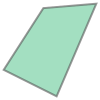

In [75]:
poly

In [ ]:
def pca(points, n_components=2):
    covar, mean = cv2.calcCovarMatrix(points, None, cv2.COVAR_SCALE | cv2.COVAR_ROWS | cv2.COVAR_SCRAMBLED)
    ret, e_vals, e_vecs = cv2.eigen(covar)
    # Conversion + normalisation required due to 'scrambled' mode
    e_vecs = cv2.gemm(e_vecs, points - mean, 1, None, 0)
    # apply_along_axis() slices 1D rows, but normalize() returns 4x1 vectors
    e_vecs = np.apply_along_axis(lambda n: cv2.normalize(n, None).flat, 1, e_vecs)
    return e_vecs[:n_components,:], e_vals[:n_components,:], mean


def linear_continuation(polygons):
    
    for p in polygons:
        if len(p.exterior.coords) < 4:
            continue
            
        mean = p.exterior.centroid
        points = np.array(p.exterior.coords)
        e_vecs, e_vals, _ = pca(points)
    

In [71]:
np.array(poly.exterior.coords)

array([[ 3259.,  1452.],
       [ 3268.,  1466.],
       [ 3280.,  1467.],
       [ 3271.,  1446.],
       [ 3259.,  1452.]])

In [94]:
def pca(points, n_components=2):
    covar, mean = cv2.calcCovarMatrix(points, None, cv2.COVAR_SCALE | cv2.COVAR_ROWS | cv2.COVAR_SCRAMBLED)
    ret, e_vals, e_vecs = cv2.eigen(covar)
    # Conversion + normalisation required due to 'scrambled' mode
    e_vecs = cv2.gemm(e_vecs, points - mean, 1, None, 0)
    # apply_along_axis() slices 1D rows, but normalize() returns 4x1 vectors
    e_vecs = np.apply_along_axis(lambda n: cv2.normalize(n, None).flat, 1, e_vecs)
    return e_vecs[:n_components,:], e_vals[:n_components,:], mean

In [95]:
pca(np.array(poly.exterior.coords))

(array([[ 0.66803756,  0.74412755],
        [ 0.74412755, -0.66803756]]), array([[ 101.80475081],
        [  31.07524919]]), array([[ 3267.4,  1456.6]]))

In [96]:
round_coords = lambda x: np.array(x).round().astype(np.int32)

In [97]:
pts = np.array(poly.exterior.coords)
pts -= np.array([3200,1400])
pts

array([[ 59.,  52.],
       [ 68.,  66.],
       [ 80.,  67.],
       [ 71.,  46.],
       [ 59.,  52.]])

In [98]:
e_vecs, e_vals, mean = pca(pts)

In [103]:
mean, e_vals, e_vecs

(array([[ 67.4,  56.6]]), array([[ 101.80475081],
        [  31.07524919]]), array([[ 0.66803756,  0.74412755],
        [ 0.74412755, -0.66803756]]))

In [104]:
e_vals[0] > 3 * e_vals[1]

array([ True], dtype=bool)

In [107]:
e_vecs[0]

array([ 0.66803756,  0.74412755])

In [173]:
img = np.zeros((100, 100), dtype=np.uint8)
exterior = [round_coords(pts)]
img = cv2.fillPoly(img, exterior, 255)

In [174]:
from visu_utils import plt_st, display_img_1b

In [183]:
pt1 = tuple(round_coords(mean)[0])
pt2 = tuple(round_coords(pt1 + 50*e_vecs[0]))
thickness = int(e_vals[1][0]) / 5

In [184]:
tuple(pt1), tuple(pt2), thickness

((67, 57), (100, 94), 6)

In [185]:
img2 = cv2.line(img.copy(), pt1, pt2, 127, thickness=thickness)

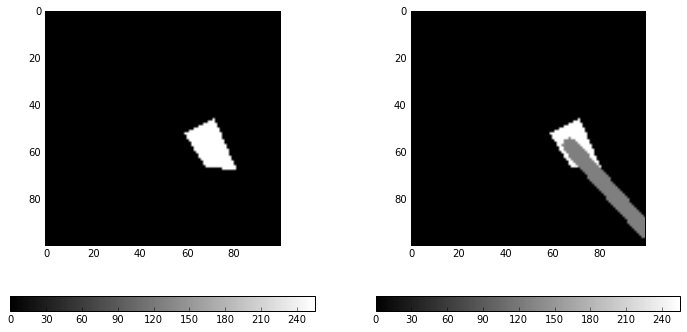

In [186]:
plt_st(12, 6)
plt.subplot(121)
display_img_1b(img)
plt.subplot(122)
display_img_1b(img2)

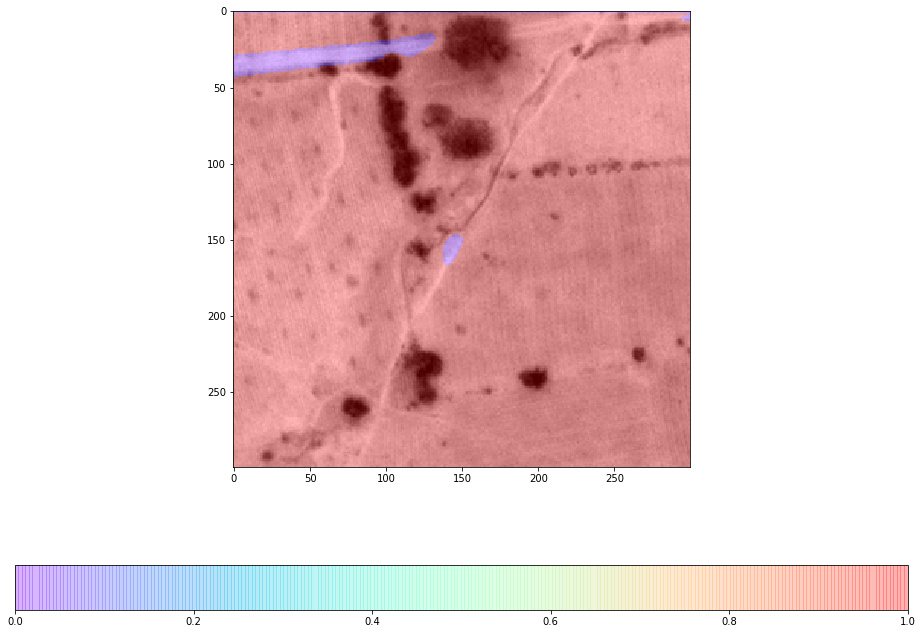

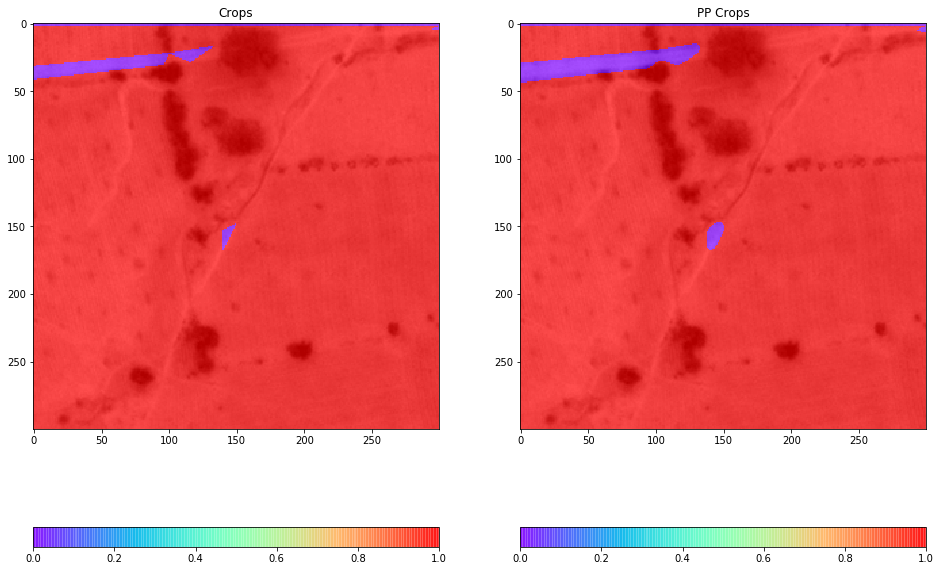

In [25]:
roi = None

# roi = [3000, 0, 3300, 300]
# roi = [0, 1500, 250, 1750]
# roi = [500, 500, 1750, 1750]
# roi = [750, 2750, 1350, 3300]

index = 4
if index in class_pp_func_list:
    bin_img = class_pp_func_list[index](labels_image[:,:,index])
else:
    bin_img = labels_image[:,:,index]

plt_st(16, 12)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(bin_img, roi, alpha=0.3, clim=[0, 1], cmap='rainbow')

plt_st(16, 12)
plt.subplot(121)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(labels_image[:,:,index], roi, alpha=0.7, clim=[0, 1], cmap='rainbow')
plt.title(LABELS[index])
plt.subplot(122)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(bin_img, roi, alpha=0.7, clim=[0, 1], cmap='rainbow')
plt.title("PP " + LABELS[index])

In [26]:
def mask_postprocessing(labels_image, class_pp_func_list):
    out = np.zeros_like(labels_image)
    for i, l in enumerate(LABELS):
        if i in class_pp_func_list:
            out[:,:,i] = class_pp_func_list[i](labels_image[:,:,i])
        else:
            out[:,:,i] = labels_image[:,:,i]
    return out

In [27]:
from data_utils import mask_to_polygons

def write_shp_from_mask(filename, image_id, labels_image):
    all_scaled_polygons = {}
    for class_index in range(1, len(LABELS[1:])):
        polygons = mask_to_polygons(labels_image[:, :, class_index])
        all_scaled_polygons[class_index] = polygons
    write_shp_from_polygons(filename, image_id, all_scaled_polygons)    

In [465]:
pp_labels_image = mask_postprocessing(labels_image, class_pp_func_list)

In [466]:
write_shp_from_mask("%s_pp.shp" % image_id, image_id, pp_labels_image)

Self-intersection at or near point 2488.7408312958437 2092.7530562347188


Written succesfully file :  6120_2_1_pp.shp


In [18]:
for class_index in range(1, len(LABELS)):
    print class_index

1
2
3
4
5
6
7
8
9
10
